In [1]:
!pip install tensorflow numpy pandas scikit-learn matplotlib nlpaug


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 5.3 MB/s eta 0:00:00


In [7]:
import nltk

# Download required NLTK resources
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Optional: WordNet's Open Multilingual Wordnet


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
import nltk
import numpy as np
import tensorflow as tf
import pickle
import os
import nlpaug.augmenter.word as naw
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# 🔹 Step 1: Download required NLTK resources
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')  # Additional requirement for tokenization

# 🔹 Step 2: Set NLTK data path manually
os.environ['NLTK_DATA'] = '/usr/local/nltk_data'

# 🔹 Step 3: Ensure "data" directory exists
os.makedirs("data", exist_ok=True)

# 🔹 Step 4: Load dataset function
def load_data(file_path):
    texts, labels = [], []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split(";")
            if len(parts) == 2:
                texts.append(parts[0])
                labels.append(parts[1])
    return texts, labels

# 🔹 Step 5: Load datasets from Google Drive
train_texts, train_labels = load_data("/content/drive/MyDrive/train.txt")
val_texts, val_labels = load_data("/content/drive/MyDrive/val.txt")
test_texts, test_labels = load_data("/content/drive/MyDrive/test.txt")

# 🔹 Step 6: Apply Data Augmentation (Synonym Replacement)
aug = naw.SynonymAug(aug_src="wordnet")
augmented_texts = []

for text in train_texts[:2000]:  # Augment only first 2000 samples
    try:
        augmented = aug.augment(text)
        if augmented:
            augmented_texts.append(augmented)
        else:
            augmented_texts.append(text)  # Use original if augmentation fails
    except Exception as e:
        print(f"⚠️ Augmentation failed for: {text} | Error: {e}")
        augmented_texts.append(text)  # Use original if augmentation crashes

# 🔹 Step 7: Extend dataset with augmented texts
train_texts.extend(augmented_texts)
train_labels.extend(train_labels[:2000])  # Duplicate corresponding labels

# 🔹 Step 8: Tokenization
max_words = 10000  # Max vocabulary size
max_len = 50       # Max sequence length
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

# Convert texts to sequences
X_train = pad_sequences(tokenizer.texts_to_sequences(train_texts), maxlen=max_len, padding="post")
X_val = pad_sequences(tokenizer.texts_to_sequences(val_texts), maxlen=max_len, padding="post")
X_test = pad_sequences(tokenizer.texts_to_sequences(test_texts), maxlen=max_len, padding="post")

# 🔹 Step 9: Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_labels)
y_val = label_encoder.transform(val_labels)
y_test = label_encoder.transform(test_labels)

# Convert labels to categorical
num_classes = len(label_encoder.classes_)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# 🔹 Step 10: Save tokenizer & label classes
with open("data/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
np.save("data/classes.npy", label_encoder.classes_)

print("✅ Data preprocessing and augmentation completed successfully!")


In [16]:
# Define Google Drive path for storage
drive_path = "/content/drive/MyDrive/"

# Ensure the directory exists
import os
os.makedirs(drive_path, exist_ok=True)

# Save processed data in Google Drive
np.save(drive_path + "X_train.npy", X_train)
np.save(drive_path + "X_val.npy", X_val)
np.save(drive_path + "X_test.npy", X_test)
np.save(drive_path + "y_train.npy", y_train)
np.save(drive_path + "y_val.npy", y_val)
np.save(drive_path + "y_test.npy", y_test)

print("✅ Processed data saved to Google Drive!")


✅ Processed data saved to Google Drive!


In [10]:
# Load GloVe embeddings
embedding_index = {}
with open("/content/drive/MyDrive/glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coef = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = coef

# Create embedding matrix
embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Define embedding layer
embedding_layer = tf.keras.layers.Embedding(
    input_dim=max_words,
    output_dim=embedding_dim,
    input_length=max_len,
    weights=[embedding_matrix],
    trainable=False  # Freeze embeddings
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Flatten, GlobalMaxPooling1D

model = Sequential([
    embedding_layer,  # GloVe embeddings
    Conv1D(128, 5, activation="relu"),
    MaxPooling1D(2),
    Bidirectional(LSTM(64, return_sequences=True)),  # BiLSTM for sequence dependencies
    GlobalMaxPooling1D(),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=64)

# Save trained model
model.save("model/cnn_bilstm_glove.h5")


Epoch 1/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 27s 81ms/step - accuracy: 0.3192 - loss: 1.6501 - val_accuracy: 0.4365 - val_loss: 1.5358
Epoch 2/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 40s 76ms/step - accuracy: 0.4466 - loss: 1.5004 - val_accuracy: 0.4995 - val_loss: 1.3615
Epoch 3/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 40s 72ms/step - accuracy: 0.5109 - loss: 1.3430 - val_accuracy: 0.5400 - val_loss: 1.2243
Epoch 4/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 23s 82ms/step - accuracy: 0.5477 - loss: 1.2367 - val_accuracy: 0.5685 - val_loss: 1.1342
Epoch 5/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.5650 - loss: 1.1695 - val_accuracy: 0.6030 - val_loss: 1.0584
Epoch 6/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.6078 - loss: 1.0853 - val_accuracy: 0.6450 - val_loss: 0.9972
Epoch 7/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 40s 79ms/step - accuracy: 0.6385 - loss: 1.0207 - val_accuracy: 0.6540 - val_loss: 0.9444
Epoch 8/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.6592 - loss: 0.9390 - 

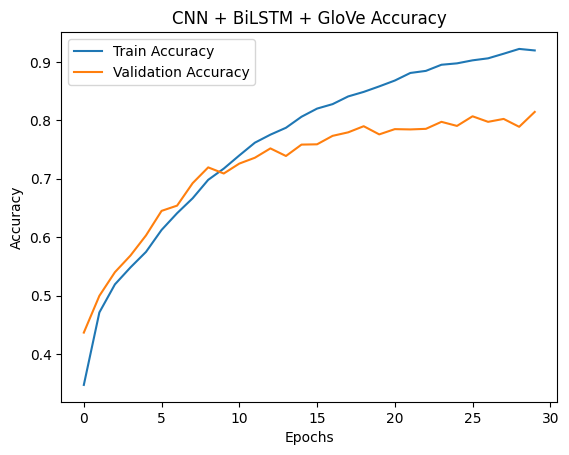

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("CNN + BiLSTM + GloVe Accuracy")
plt.show()


In [20]:
# Define Google Drive path
drive_path = "/content/drive/MyDrive"

# Load test data from Google Drive
X_test = np.load("/content/drive/MyDrive/X_test.npy")
y_test = np.load("/content/drive/MyDrive/y_test.npy")

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)

# Convert accuracy to percentage and print
test_acc_percent = test_acc * 100
print(f"✅ Test Accuracy: {test_acc_percent:.2f}%")


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8035 - loss: 0.6030
✅ Test Accuracy: 80.00%


In [21]:
# Load tokenizer & model
with open("data/tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

model = tf.keras.models.load_model("model/cnn_bilstm_glove.h5")
label_classes = np.load("data/classes.npy")

# Predict function
def predict_emotion(text):
    seq = tokenizer.texts_to_sequences([text])
    padded_seq = pad_sequences(seq, maxlen=50, padding="post")
    prediction = model.predict(padded_seq)
    emotion = label_classes[np.argmax(prediction)]
    return emotion

# User input for emotion detection
while True:
    text = input("Enter a sentence (or 'exit' to quit): ")
    if text.lower() == "exit":
        break
    print(f"Predicted Emotion: {predict_emotion(text)}")


Enter a sentence (or 'exit' to quit): i get giddy over feeling elegant in a perfectly fitted pencil skirt
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
Predicted Emotion: joy
Enter a sentence (or 'exit' to quit): i remember feeling acutely distressed for a few days
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Emotion: fear
Enter a sentence (or 'exit' to quit): i was feeling listless from the need of new things something different
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted Emotion: sadness
Enter a sentence (or 'exit' to quit): i feel selfish and spoiled
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Emotion: anger
Enter a sentence (or 'exit' to quit): i keep feeling pleasantly surprised at his supportiveness and also his ease in new situations
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted Emotion: surprise
Enter a sentence (or 'exit' to quit): i was ready to meet mom in the airport and feel her ever supportive arms around me
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Emotion: l